### Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

In [2]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


### Download the dataset from Kaggle
https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [3]:
movie_reviews = pd.read_csv("IMDB_Dataset.csv")

### Data Exploration

In [4]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
movie_reviews.isnull().values.any()

False

In [6]:
movie_reviews.shape

(50000, 2)

In [7]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

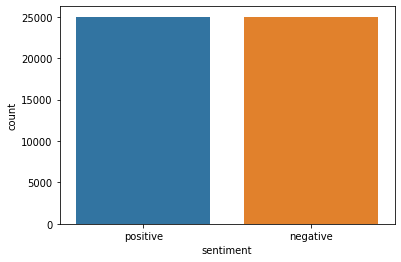

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.countplot(x='sentiment', data=movie_reviews)

### Pre-processing of text
- Removing html tags
- Removing punctutations and numbers
- Removing Multiple spaces
- so on

In [10]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [11]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [12]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [13]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

### Creating numerical labels from categorical values

In [14]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

### Split the dataset to train and test

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Use Tokenizer to integer encode the documents

In [16]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

### Pad Sequences to create equal-length inputs

In [17]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

### Load GloVe embedding into memory

In [18]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

### Create Embedding matrix for our Kaggle dataset

In [19]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### Build the model - Basic Neural Network

In [20]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

### Compile the model

In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10001     
Total params: 9,264,701
Trainable params: 10,001
Non-trainable params: 9,254,700
_________________________________________________________________
None


### Fit the model

In [22]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)


Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 1s 30us/step - loss: 0.5995 - acc: 0.6751 - val_loss: 0.5591 - val_acc: 0.7132
Epoch 2/6
32000/32000 [==============================] - 1s 20us/step - loss: 0.4938 - acc: 0.7622 - val_loss: 0.5318 - val_acc: 0.7335
Epoch 3/6
32000/32000 [==============================] - 1s 28us/step - loss: 0.4603 - acc: 0.7864 - val_loss: 0.5184 - val_acc: 0.7429
Epoch 4/6
32000/32000 [==============================] - 1s 25us/step - loss: 0.4354 - acc: 0.8004 - val_loss: 0.5231 - val_acc: 0.7427
Epoch 5/6
32000/32000 [==============================] - 1s 18us/step - loss: 0.4207 - acc: 0.8073 - val_loss: 0.5624 - val_acc: 0.7314
Epoch 6/6
32000/32000 [==============================] - 1s 19us/step - loss: 0.4076 - acc: 0.8147 - val_loss: 0.5402 - val_acc: 0.7404


### Evaluate Training phase

In [28]:
score = model.evaluate(X_train, y_train, verbose=1)
score

40000/40000 [==============================] - 1s 25us/step


[0.4058288911938667, 0.819350004196167]

In [29]:
print("Train Loss:", score[0])
print("Train Accuracy:", score[1])

Train Loss: 0.4058288911938667
Train Accuracy: 0.819350004196167


### Evaluate Testing phase

In [33]:
score = model.evaluate(X_test, y_test, verbose=1)

10000/10000 [==============================] - 0s 32us/step


In [34]:
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.5410662783622742
Test Accuracy: 0.7423999905586243


### Plot the training and testing accuracy and loss

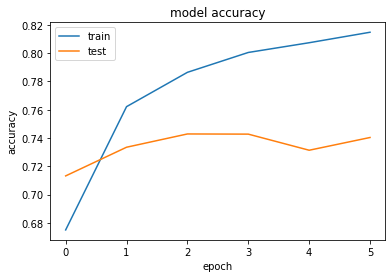

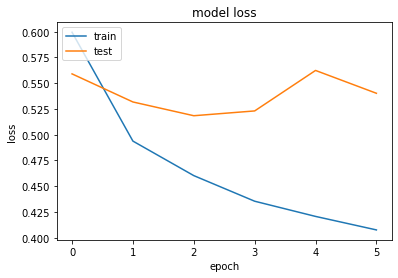

In [36]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### What's happening here?